In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time
import json
import pprint

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models

from build_model_ed import build_model_1, build_model_2, build_model_3
from build_model_lstm import build_model_lstm_1, build_model_lstm_2, build_model_lstm_3
from get_frames import get_frames
from get_encoder_decoder import get_encoder_decoder
from get_errors import get_ssim, get_mse, get_errors
from assemble_image import assemble_image
from load_models import load_encoder_decoder_model, load_lstm_model, load_classification_model, load_models
from prediction import predict_step, predict_image, classify_image_frames
from plot_prediction import plot_prediction, plot_probabilities
from get_labels import get_labels, get_defect_label
from load_image import load_image

from run_prediction import run_prediction

In [4]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#load data image list
test_size = 0.1
stride_step = 50
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_test_all_str_50_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
#load data
with open(filename, 'rb') as f:
    image_list,frames_data = pickle.load(f)
    
del frames_data

#image list
print('Image list:')
print('\n'.join([f'{i}: {image}' for i, image in enumerate(image_list)]))

#load labels
file_name = f'defects_borders.json'
folder = f'save_data/classify_data'  

with open(f'{folder}/{file_name}', 'r') as f:
    borders_dict = json.load(f)
    
defect_type_dict = {
    0:'No defect',
    1:'Twist',
    2:'Puck',
    3:'Fold'
    }

Image list:
0: Fold21.png
1: Pucker3.png
2: Fold3.png
3: Pucker23.png
4: Pucker16.png
5: Twist31.png
6: Pucker7.png
7: Pucker26.png
8: Pucker24.png


In [6]:
stride_step = 50
unit_numb_list = [5,30]
window_size, window_size_predicted, overlap = (6,1,0)
#how many frames to predict within a single step
repeat_prediction = 6
#how many steps
frames_to_pred_total = 69
#lstm settings
lstm_type = 'win'
stateful = False
#load classifier model
classifier=True
verbose = 0
#whether consider only gt input (6 frames) for classification (value=2)
#or consider both input gt and to-be-predicted gt (12 frames) for classification (value=1)
gt_label_mode = 2

encoder_pars_dict = {
    'stride_step':stride_step,
    'unit_numb_list':unit_numb_list,
}

lstm_pars_dict = {
    'stateful':stateful,
    'window_size':window_size,
    'window_size_predicted':window_size_predicted,
    'overlap':overlap,
    'repeat_prediction':repeat_prediction,
    'frames_to_pred_total':frames_to_pred_total,
    'lstm_type':lstm_type,
    'gt_label_mode':gt_label_mode,
}

classifier_pars_dict = {
    'classifier':classifier,
}

plot_settings_dict = {
    'ifMetrics':True,
    'ifSave':False,
    'save_folder':f'pictures/paper_pictures/new/stride_{stride_step}/pucker19',
    'ifClose':True,
    'ifSingle':True,
    'numb_cols':3,
}

padding_dict = {
    'ifPadding':True,
    'max_window_size':12,        
}

Image shape: (2048, 4000, 3)


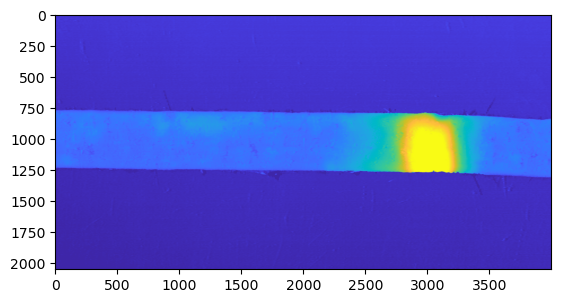

In [7]:
#choose image
#test_case = image_list[7]
test_case = 'Pucker19.png'
image_data_gt = load_image(test_case)
print(f'Image shape: {image_data_gt.shape}')
plt.imshow(image_data_gt)

In [8]:
image_data_frames_gt, predicted_data_dict, labels_dict = run_prediction(
    test_case, 
    borders_dict, 
    encoder_pars_dict, 
    lstm_pars_dict, 
    classifier_pars_dict, 
    plot_settings_dict, 
    verbose
)

In [ ]:
plot_prediction(
    image_data_frames_gt,
    predicted_data_dict,
    labels_dict,
    lstm_pars_dict,
    plot_settings_dict,
)

In [30]:
plot_settings_dict['ifSave'] = True

#get labels from classifier
#bassam's approach
models_dict = load_models(unit_numb_list[0], stride_step, lstm_pars_dict, classifier=classifier)
if 0:
    #use classifier to get real sensor labels
    labels = classify_image_frames(test_case, stride_step, 12, padding_dict, borders_dict, models_dict)
else:
    #use gt labels
    defect_type = get_defect_label(test_case)
    borders_list = borders_dict[test_case]
    image_length = image_data_gt.shape[1]
    
    labels = get_labels(
        stride_step,
        borders_list, 
        image_length, 
        12, 
        defect_type
    )
#modify labels dictionary
#for that option window_total = window_total//2 is commented out in plot_probabilities function
labels_modified_dict = {}
labels_modified_dict['gt'] = labels[:-6]
for key in labels_dict.keys():
    if type(key)!=int:
        #skip gt key
        continue
    labels_modified_dict[key] = [label_array[6:] for label_array in labels_dict[key]]

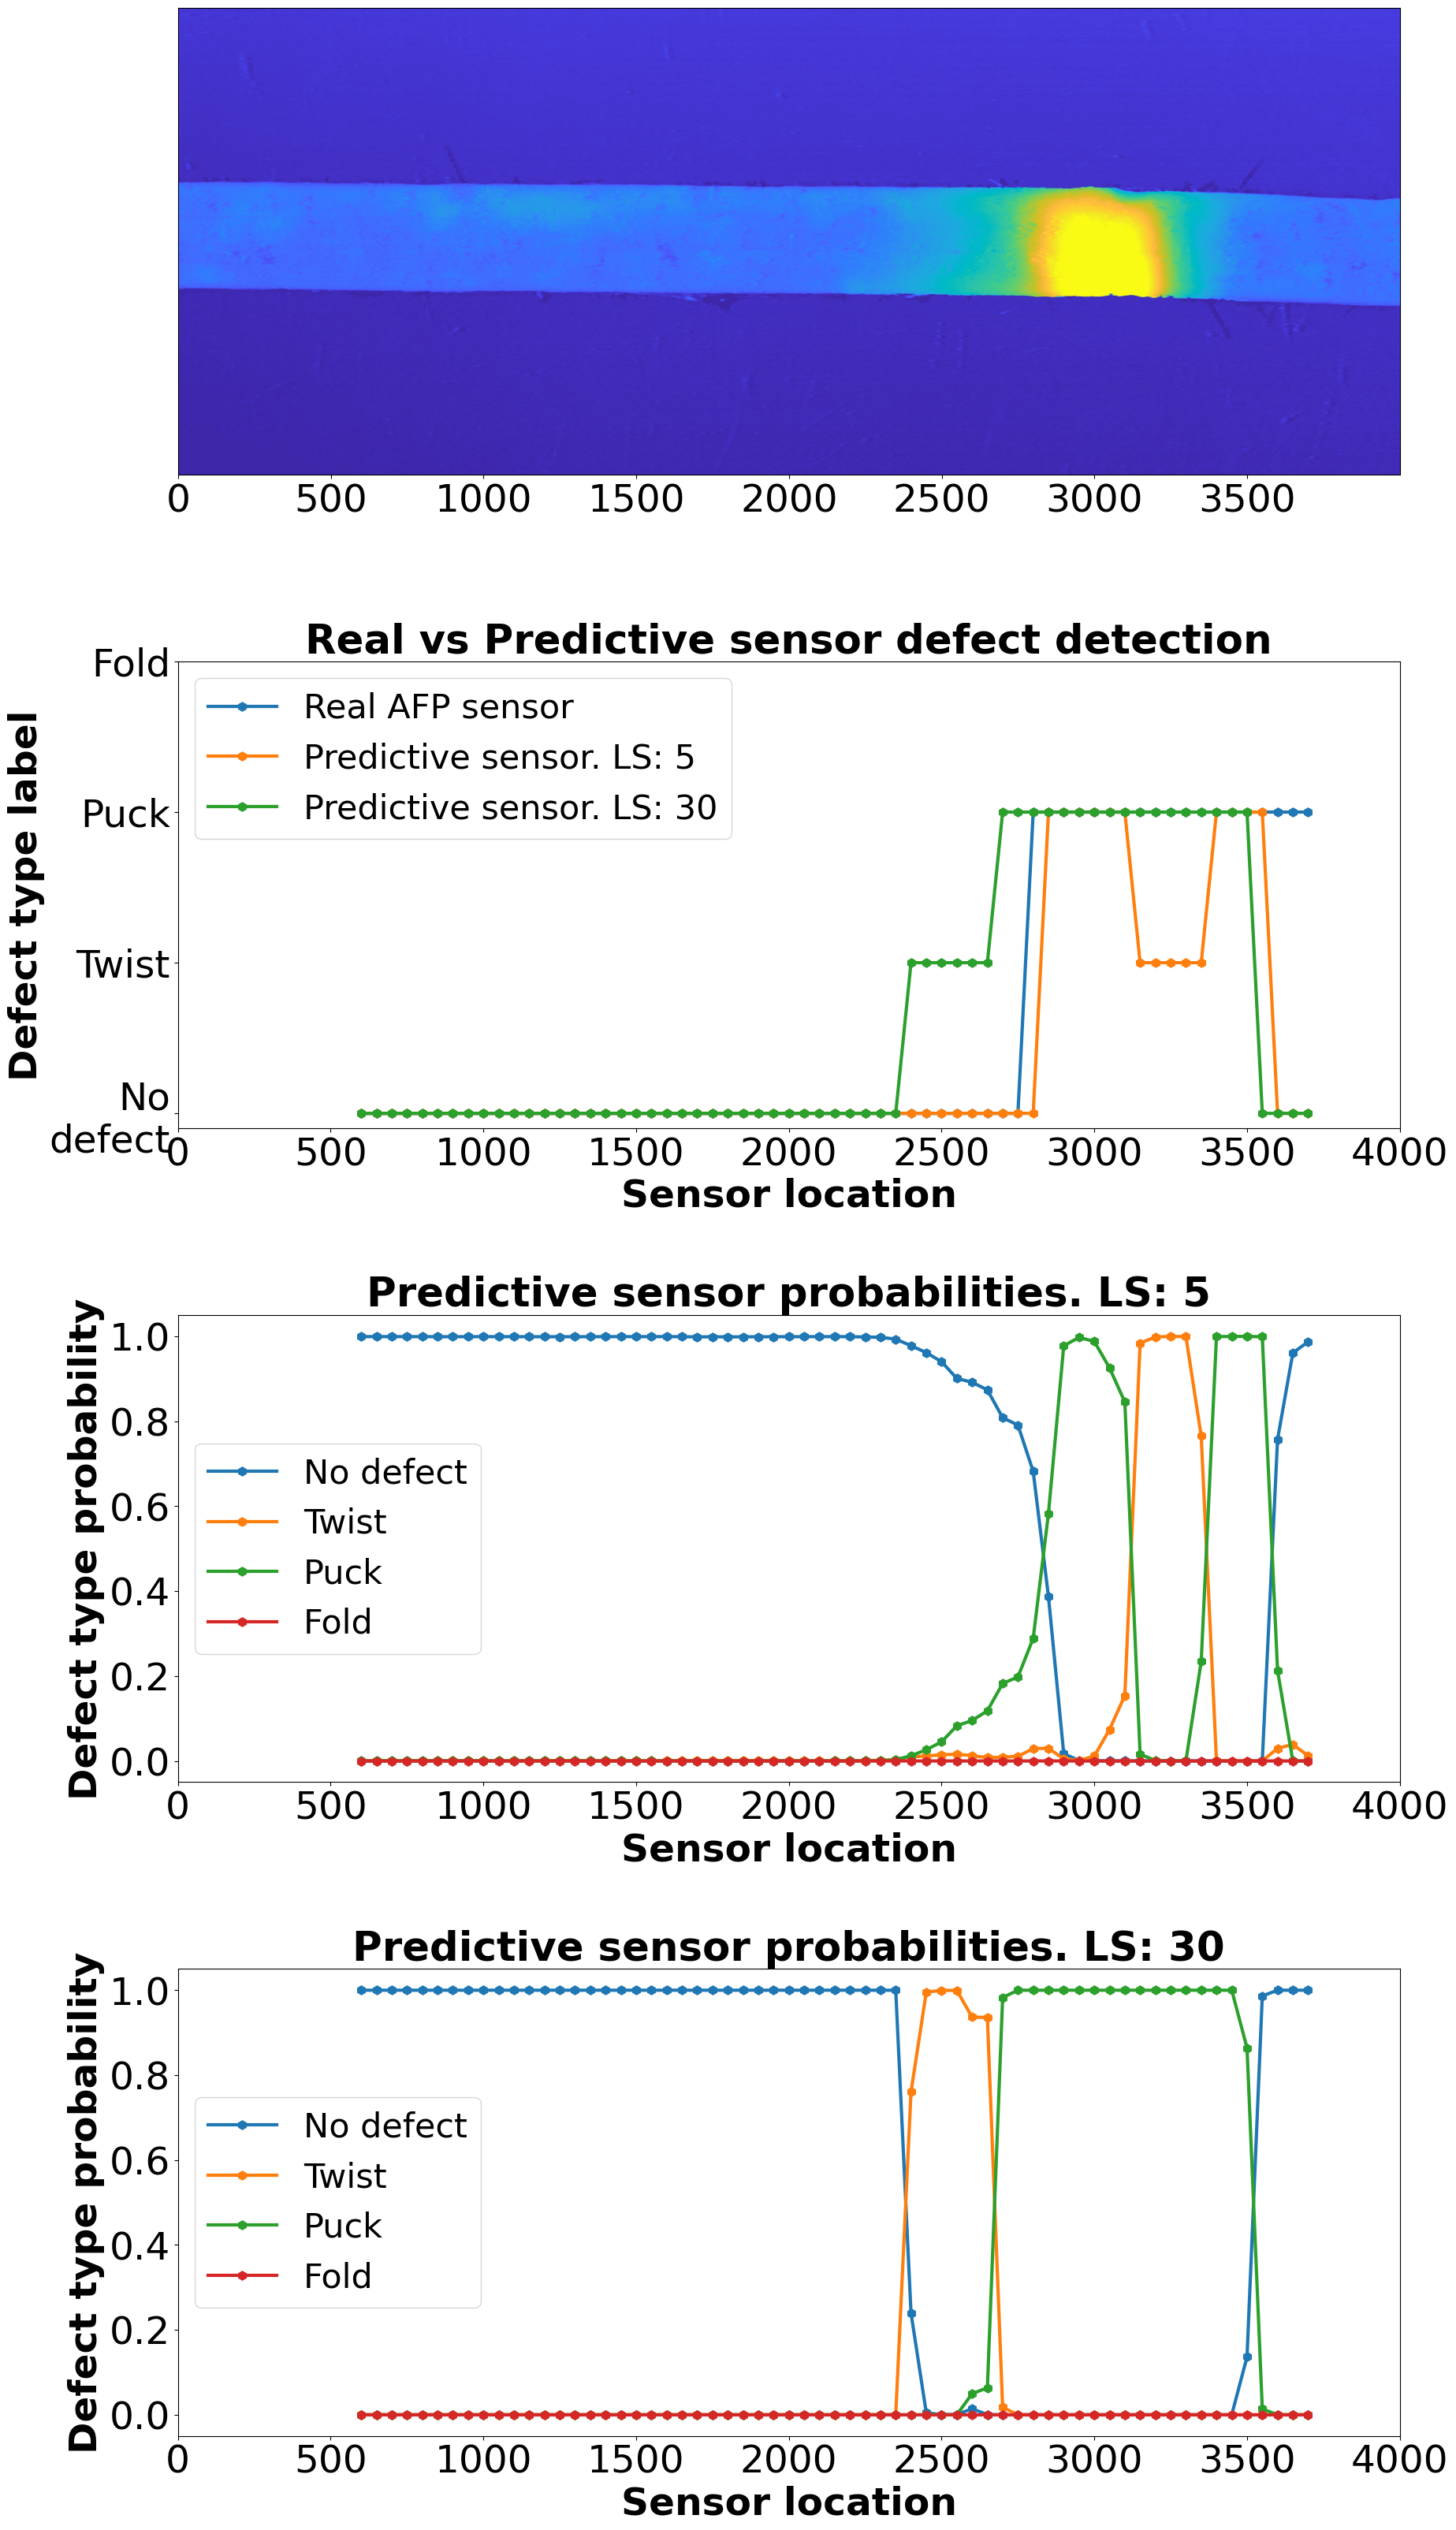

In [31]:
plot_probabilities(labels_modified_dict, lstm_pars_dict, stride_step, test_case, plot_settings_dict)